# News Headlines Web Scraping & Classification Demo

This notebook demonstrates how to collect real news article titles through web scraping and then train our topic classifier on this live data. We'll explore various web scraping techniques while maintaining ethical practices.

**What You'll Learn:**
- 🕷️ Web scraping fundamentals with requests and BeautifulSoup
- 🔍 Different approaches for extracting article titles
- ⚖️ Ethical scraping practices and rate limiting
- 🏷️ Automatic topic categorization from website sections
- 🧠 Training a classifier on real-world scraped data

**Important Note:** Always respect website terms of service and implement appropriate delays between requests. This demo uses publicly accessible content for educational purposes.

---

## 1. Understanding Web Scraping Fundamentals

Before we dive into code, let's understand what web scraping involves. Think of web scraping like reading a newspaper, but instead of using your eyes, we're teaching a computer to "read" the webpage and extract specific information.

**The Process:**
1. **Send Request** → Like asking for a specific newspaper
2. **Receive HTML** → Getting the raw newspaper content
3. **Parse Structure** → Understanding the layout and finding articles
4. **Extract Data** → Pulling out just the headlines we want
5. **Store Results** → Organizing our collected headlines

Let's start by setting up our tools.

In [1]:
# Essential libraries for web scraping
import requests  # For making HTTP requests to websites
from bs4 import BeautifulSoup  # For parsing HTML content
import time  # For adding delays between requests
import random  # For randomizing delays
from urllib.parse import urljoin, urlparse  # For handling URLs
from urllib.robotparser import RobotFileParser  # For checking robots.txt

# Standard data processing libraries
import pandas as pd
import numpy as np
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Our model components (same as before)
import sys
import os
if '../src' not in sys.path:
    sys.path.insert(0, '../src')
if './src' not in sys.path:
    sys.path.insert(0, './src')

print("🔧 Web scraping toolkit loaded!")
print(f"   📡 Requests version: {requests.__version__}")
print(f"   🍲 BeautifulSoup available: {BeautifulSoup.__name__}")
print(f"   ⏰ Ready to scrape responsibly!")

🔧 Web scraping toolkit loaded!
   📡 Requests version: 2.31.0
   🍲 BeautifulSoup available: BeautifulSoup
   ⏰ Ready to scrape responsibly!


## 2. Ethical Scraping Setup

Before we start scraping, we need to establish ethical guidelines. Think of this like learning the rules of the road before driving - it keeps everyone safe and ensures we can continue using these resources.

**Key Principles:**
- **Respect robots.txt** → Check if the website allows automated access
- **Use delays** → Don't overwhelm servers with rapid requests
- **Identify yourself** → Use a proper User-Agent string
- **Start small** → Test with a few pages before scaling up

In [2]:
class EthicalScraper:
    """
    A responsible web scraper that follows ethical guidelines.
    Think of this as our 'polite robot' that asks permission before taking.
    """
    
    def __init__(self, delay_range=(1, 3), user_agent=None):
        """
        Initialize our ethical scraper.
        
        delay_range: Tuple of (min, max) seconds to wait between requests
        user_agent: How we identify ourselves to websites
        """
        self.delay_range = delay_range
        self.session = requests.Session()
        
        # Set a respectful user agent - like introducing ourselves
        if user_agent is None:
            user_agent = (
                "Mozilla/5.0 (Educational Research Bot) "
                "HeadlineClassifier/1.0 (+Educational Use Only)"
            )
        
        self.session.headers.update({
            'User-Agent': user_agent,
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
        })
        
        print(f"🤖 Ethical scraper initialized:")
        print(f"   ⏱️ Delay range: {delay_range[0]}-{delay_range[1]} seconds")
        print(f"   🆔 User agent: {user_agent[:50]}...")
    
    def can_scrape(self, url):
        """
        Check if we're allowed to scrape this URL by checking robots.txt.
        This is like checking if there's a 'No Solicitors' sign before knocking.
        """
        try:
            parsed_url = urlparse(url)
            robots_url = f"{parsed_url.scheme}://{parsed_url.netloc}/robots.txt"
            
            rp = RobotFileParser()
            rp.set_url(robots_url)
            rp.read()
            
            # Check if our user agent can fetch this URL
            can_fetch = rp.can_fetch('*', url)
            print(f"   🤖 robots.txt check for {parsed_url.netloc}: {'✅ Allowed' if can_fetch else '❌ Blocked'}")
            return can_fetch
            
        except Exception as e:
            print(f"   ⚠️ Could not check robots.txt: {e}")
            return True  # If we can't check, proceed cautiously
    
    def polite_delay(self):
        """
        Wait a random amount of time between requests.
        This prevents overwhelming the server - like pausing between knocks.
        """
        delay = random.uniform(*self.delay_range)
        print(f"   ⏸️ Waiting {delay:.1f} seconds to be polite...")
        time.sleep(delay)
    
    def fetch_page(self, url, check_robots=True):
        """
        Fetch a webpage responsibly.
        Returns the response object or None if something goes wrong.
        """
        # Check permissions first
        if check_robots and not self.can_scrape(url):
            print(f"❌ Skipping {url} - not allowed by robots.txt")
            return None
        
        try:
            print(f"📡 Fetching: {url}")
            response = self.session.get(url, timeout=10)
            response.raise_for_status()  # Raise an exception for bad status codes
            
            print(f"   ✅ Success! Got {len(response.content)} bytes")
            return response
            
        except requests.exceptions.RequestException as e:
            print(f"   ❌ Error fetching {url}: {e}")
            return None
        
        finally:
            # Always be polite - wait before the next request
            self.polite_delay()

# Initialize our ethical scraper
scraper = EthicalScraper(delay_range=(2, 4))  # 2-4 second delays

🤖 Ethical scraper initialized:
   ⏱️ Delay range: 2-4 seconds
   🆔 User agent: Mozilla/5.0 (Educational Research Bot) HeadlineCla...


## 3. Defining Target Websites

Now we'll identify websites to scrape from. I've chosen sites that are commonly used for educational web scraping and have clear section-based organization that will help us automatically categorize our headlines.

**Strategy:** We'll focus on sites with clear URL patterns where different sections (like `/politics/`, `/technology/`) indicate the topic. This lets us automatically label our data as we collect it.

In [3]:
# Define our scraping targets with their topic sections
SCRAPING_TARGETS = {
    'reuters': {
        'base_url': 'https://www.reuters.com',
        'sections': {
            'politics': '/politics/',
            'technology': '/technology/',
            'business': '/business/',
            'sports': '/sports/'
        },
        'headline_selector': 'a[data-testid="Heading"]',  # CSS selector for headlines
        'description': 'Reuters - International news agency'
    },
    'bbc': {
        'base_url': 'https://www.bbc.com/news',
        'sections': {
            'politics': '/politics',
            'technology': '/technology',
            'business': '/business',
            'sports': '/sport'
        },
        'headline_selector': 'h3[class*="headline"], h2[class*="headline"], .gs-c-promo-heading__title',
        'description': 'BBC News - British public broadcaster'
    },
    'guardian': {
        'base_url': 'https://www.theguardian.com',
        'sections': {
            'politics': '/politics',
            'technology': '/technology',
            'business': '/business', 
            'sports': '/sport'
        },
        'headline_selector': 'h3 a, .fc-item__title a, [data-testid="headline"]',
        'description': 'The Guardian - British daily newspaper'
    }
}

print("🎯 Scraping targets configured:")
print()
for site_name, config in SCRAPING_TARGETS.items():
    print(f"📰 {site_name.upper()}")
    print(f"   🌐 Base URL: {config['base_url']}")
    print(f"   📊 Sections: {list(config['sections'].keys())}")
    print(f"   🔍 CSS Selector: {config['headline_selector'][:50]}...")
    print(f"   📝 {config['description']}")
    print()

print("💡 Why these sites?")
print("   • Well-structured HTML that's easier to parse")
print("   • Clear topic sections for automatic labeling")
print("   • Generally allow educational scraping")
print("   • Reliable sources for diverse headlines")

🎯 Scraping targets configured:

📰 REUTERS
   🌐 Base URL: https://www.reuters.com
   📊 Sections: ['politics', 'technology', 'business', 'sports']
   🔍 CSS Selector: a[data-testid="Heading"]...
   📝 Reuters - International news agency

📰 BBC
   🌐 Base URL: https://www.bbc.com/news
   📊 Sections: ['politics', 'technology', 'business', 'sports']
   🔍 CSS Selector: h3[class*="headline"], h2[class*="headline"], .gs-...
   📝 BBC News - British public broadcaster

📰 GUARDIAN
   🌐 Base URL: https://www.theguardian.com
   📊 Sections: ['politics', 'technology', 'business', 'sports']
   🔍 CSS Selector: h3 a, .fc-item__title a, [data-testid="headline"]...
   📝 The Guardian - British daily newspaper

💡 Why these sites?
   • Well-structured HTML that's easier to parse
   • Clear topic sections for automatic labeling
   • Generally allow educational scraping
   • Reliable sources for diverse headlines


## 4. Headline Extraction Functions

Now we'll create functions to extract headlines from webpages. Think of this as teaching our computer to "read" a webpage like you would - looking for the important headlines while ignoring ads, menus, and other distractions.

**The Challenge:** Every website structures their content differently, so we need flexible approaches to find headlines regardless of the specific HTML structure.

In [4]:
def extract_headlines_from_page(html_content, css_selectors, max_headlines=20):
    """
    Extract headlines from HTML content using CSS selectors.
    
    Think of CSS selectors like giving directions:
    - 'h1' means "find all main headings"
    - '.headline' means "find all elements with class 'headline'"
    - 'a[data-testid="title"]' means "find links with specific attributes"
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    headlines = []
    
    # Try each CSS selector until we find headlines
    for selector in css_selectors.split(', '):
        selector = selector.strip()
        print(f"   🔍 Trying selector: {selector}")
        
        elements = soup.select(selector)
        print(f"   📊 Found {len(elements)} elements")
        
        for element in elements:
            # Extract text - could be in the element itself or in a child link
            headline_text = None
            
            if element.name == 'a':  # If it's a link, get the text
                headline_text = element.get_text(strip=True)
            else:  # If it's a container, look for a link inside
                link = element.find('a')
                if link:
                    headline_text = link.get_text(strip=True)
                else:
                    headline_text = element.get_text(strip=True)
            
            # Clean and validate the headline
            if headline_text and len(headline_text) > 10 and len(headline_text) < 200:
                # Remove extra whitespace and newlines
                cleaned_headline = ' '.join(headline_text.split())
                if cleaned_headline not in headlines:  # Avoid duplicates
                    headlines.append(cleaned_headline)
                    
                    if len(headlines) >= max_headlines:
                        print(f"   ✅ Reached maximum of {max_headlines} headlines")
                        return headlines
        
        # If we found headlines with this selector, don't try others
        if headlines:
            print(f"   ✅ Successfully extracted {len(headlines)} headlines")
            break
    
    return headlines


def smart_headline_finder(html_content, max_headlines=15):
    """
    A more intelligent approach that looks for headline patterns.
    This is like having backup strategies if our main approach doesn't work.
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    headlines = []
    
    # Strategy 1: Look for common headline patterns
    headline_patterns = [
        'h1, h2, h3',  # Header tags
        '[class*="headline"]',  # Anything with "headline" in class name
        '[class*="title"]',     # Anything with "title" in class name
        'article h1, article h2, article h3',  # Headers inside articles
        'a[href*="/article/"], a[href*="/news/"], a[href*="/story/"]',  # News article links
    ]
    
    for pattern in headline_patterns:
        print(f"   🔍 Trying pattern: {pattern}")
        elements = soup.select(pattern)
        
        for element in elements[:max_headlines]:
            text = element.get_text(strip=True)
            
            # Filter out navigation, ads, and other non-headline content
            if (text and 
                len(text) > 15 and len(text) < 150 and  # Reasonable length
                not text.lower().startswith(('menu', 'nav', 'search', 'login', 'subscribe')) and
                not text.endswith(('...', 'more', 'read more')) and
                text not in headlines):
                
                headlines.append(text)
        
        if len(headlines) >= max_headlines:
            break
    
    return headlines[:max_headlines]


def test_headline_extraction():
    """
    Test our extraction functions with a simple example.
    This helps us understand how the parsing works.
    """
    sample_html = """
    <html>
        <body>
            <h1>Main Site Title</h1>
            <nav>Navigation Menu</nav>
            <article>
                <h2><a href="/news/1">Government Announces New Policy Changes</a></h2>
                <h3 class="headline">Tech Company Reports Record Earnings</h3>
                <div class="story-title">
                    <a href="/sports/1">Football Team Wins Championship</a>
                </div>
            </article>
        </body>
    </html>
    """
    
    print("🧪 Testing headline extraction with sample HTML:")
    headlines = smart_headline_finder(sample_html)
    
    for i, headline in enumerate(headlines, 1):
        print(f"   {i}. {headline}")
    
    return len(headlines) > 0

# Run the test
test_successful = test_headline_extraction()
print(f"\n{'✅' if test_successful else '❌'} Headline extraction test {'passed' if test_successful else 'failed'}!")

🧪 Testing headline extraction with sample HTML:
   🔍 Trying pattern: h1, h2, h3
   🔍 Trying pattern: [class*="headline"]
   🔍 Trying pattern: [class*="title"]
   🔍 Trying pattern: article h1, article h2, article h3
   🔍 Trying pattern: a[href*="/article/"], a[href*="/news/"], a[href*="/story/"]
   1. Government Announces New Policy Changes
   2. Tech Company Reports Record Earnings
   3. Football Team Wins Championship

✅ Headline extraction test passed!


## 5. Live Web Scraping Demo

Now comes the exciting part - let's actually scrape some real headlines! We'll start with a single site to see how the process works, then expand to multiple sources.

**What to Watch For:**
- How we respect rate limits with delays
- Different extraction strategies for different sites
- Automatic topic categorization based on URL sections
- Error handling when things don't go as planned

In [5]:
def scrape_headlines_from_site(site_name, site_config, topics_to_scrape=None, max_per_topic=10):
    """
    Scrape headlines from a specific news site.
    
    This function demonstrates the complete scraping workflow:
    1. Check each topic section
    2. Fetch the page content
    3. Extract headlines using our strategies
    4. Label headlines with their topic
    5. Return organized results
    """
    print(f"\n🕷️ Scraping headlines from {site_name.upper()}")
    print(f"📝 {site_config['description']}")
    print("=" * 50)
    
    all_headlines = []
    
    # If no specific topics requested, scrape all available
    if topics_to_scrape is None:
        topics_to_scrape = list(site_config['sections'].keys())
    
    for topic in topics_to_scrape:
        if topic not in site_config['sections']:
            print(f"⚠️ Topic '{topic}' not available for {site_name}")
            continue
        
        print(f"\n📰 Scraping {topic.upper()} headlines...")
        
        # Build the URL for this topic section
        section_url = site_config['base_url'] + site_config['sections'][topic]
        
        # Fetch the page
        response = scraper.fetch_page(section_url)
        
        if response is None:
            print(f"   ❌ Could not fetch {topic} section")
            continue
        
        # Try the site-specific CSS selector first
        headlines = extract_headlines_from_page(
            response.text, 
            site_config['headline_selector'], 
            max_headlines=max_per_topic
        )
        
        # If that didn't work, try our smart finder
        if not headlines:
            print(f"   🔄 Site-specific selector failed, trying smart finder...")
            headlines = smart_headline_finder(response.text, max_headlines=max_per_topic)
        
        # Process and store the headlines
        for headline in headlines:
            all_headlines.append({
                'headline': headline,
                'topic': topic,
                'source': site_name,
                'url': section_url,
                'scraped_at': datetime.now().isoformat()
            })
        
        print(f"   ✅ Collected {len(headlines)} {topic} headlines")
        
        # Show a sample headline
        if headlines:
            print(f"   📄 Sample: \"{headlines[0][:60]}...\"")
    
    print(f"\n🎯 Total headlines from {site_name}: {len(all_headlines)}")
    return all_headlines


# Let's start by scraping from one site to see how it works
print("🚀 Starting live web scraping demo...")
print("\n💡 We'll start with Reuters as they have a clear structure")

# Scrape headlines from Reuters (start small)
reuters_headlines = scrape_headlines_from_site(
    'reuters', 
    SCRAPING_TARGETS['reuters'],
    topics_to_scrape=['politics', 'technology'],  # Just 2 topics for demo
    max_per_topic=8
)

🚀 Starting live web scraping demo...

💡 We'll start with Reuters as they have a clear structure

🕷️ Scraping headlines from REUTERS
📝 Reuters - International news agency

📰 Scraping POLITICS headlines...
   🤖 robots.txt check for www.reuters.com: ✅ Allowed
📡 Fetching: https://www.reuters.com/politics/
   ❌ Error fetching https://www.reuters.com/politics/: 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/politics/
   ⏸️ Waiting 2.9 seconds to be polite...
   ❌ Could not fetch politics section

📰 Scraping TECHNOLOGY headlines...
   🤖 robots.txt check for www.reuters.com: ✅ Allowed
📡 Fetching: https://www.reuters.com/technology/
   ❌ Error fetching https://www.reuters.com/technology/: 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/technology/
   ⏸️ Waiting 2.4 seconds to be polite...
   ❌ Could not fetch technology section

🎯 Total headlines from reuters: 0


## 6. Expanding to Multiple Sources

Now that we've seen how scraping works with one site, let's expand to multiple sources. This gives us more diverse headlines and helps create a more robust dataset. 

**Why Multiple Sources?**
- **Diversity:** Different sites have different writing styles
- **Robustness:** If one site fails, we still have data
- **Balance:** Different perspectives on the same topics
- **Scale:** More headlines means better training data

In [6]:
def scrape_all_sources(max_per_topic_per_source=5):
    """
    Scrape headlines from all configured sources.
    We'll be conservative with numbers to avoid overwhelming servers.
    """
    print("🌐 Scraping from multiple news sources...")
    print(f"📊 Target: {max_per_topic_per_source} headlines per topic per source")
    print("\n⚠️ This will take several minutes due to polite delays between requests")
    
    all_scraped_data = []
    scraping_summary = {}
    
    # Target topics that work well across sites
    target_topics = ['politics', 'technology', 'business']
    
    for site_name, site_config in SCRAPING_TARGETS.items():
        print(f"\n{'='*60}")
        
        try:
            site_headlines = scrape_headlines_from_site(
                site_name, 
                site_config,
                topics_to_scrape=target_topics,
                max_per_topic=max_per_topic_per_source
            )
            
            all_scraped_data.extend(site_headlines)
            scraping_summary[site_name] = {
                'total_headlines': len(site_headlines),
                'by_topic': {}
            }
            
            # Count headlines by topic for this source
            for headline_data in site_headlines:
                topic = headline_data['topic']
                if topic not in scraping_summary[site_name]['by_topic']:
                    scraping_summary[site_name]['by_topic'][topic] = 0
                scraping_summary[site_name]['by_topic'][topic] += 1
            
        except Exception as e:
            print(f"❌ Error scraping {site_name}: {e}")
            scraping_summary[site_name] = {'error': str(e)}
    
    return all_scraped_data, scraping_summary


# Execute the multi-source scraping
print("⏳ Starting comprehensive scraping...")
scraped_headlines, summary = scrape_all_sources(max_per_topic_per_source=6)

# Display results summary
print("\n" + "="*60)
print("📊 SCRAPING RESULTS SUMMARY")
print("="*60)

total_headlines = len(scraped_headlines)
print(f"\n🎯 Total Headlines Collected: {total_headlines}")

for site_name, site_summary in summary.items():
    if 'error' in site_summary:
        print(f"\n❌ {site_name.upper()}: Failed ({site_summary['error']})")
    else:
        print(f"\n✅ {site_name.upper()}: {site_summary['total_headlines']} headlines")
        for topic, count in site_summary['by_topic'].items():
            print(f"   📰 {topic}: {count} headlines")

# Show some sample headlines
if scraped_headlines:
    print(f"\n📄 Sample Headlines Collected:")
    for i, item in enumerate(scraped_headlines[:6], 1):
        print(f"   {i}. [{item['topic']}] {item['headline'][:60]}...")
        print(f"      Source: {item['source']}")
else:
    print("\n⚠️ No headlines were successfully scraped. Check network connection and try again.")

⏳ Starting comprehensive scraping...
🌐 Scraping from multiple news sources...
📊 Target: 6 headlines per topic per source

⚠️ This will take several minutes due to polite delays between requests


🕷️ Scraping headlines from REUTERS
📝 Reuters - International news agency

📰 Scraping POLITICS headlines...
   🤖 robots.txt check for www.reuters.com: ✅ Allowed
📡 Fetching: https://www.reuters.com/politics/
   ❌ Error fetching https://www.reuters.com/politics/: 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/politics/
   ⏸️ Waiting 2.7 seconds to be polite...
   ❌ Could not fetch politics section

📰 Scraping TECHNOLOGY headlines...
   🤖 robots.txt check for www.reuters.com: ✅ Allowed
📡 Fetching: https://www.reuters.com/technology/
   ❌ Error fetching https://www.reuters.com/technology/: 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/technology/
   ⏸️ Waiting 3.8 seconds to be polite...
   ❌ Could not fetch technology section

📰 Scraping BUSINESS headlines...

## 7. Data Cleaning and Preparation

Now that we have scraped headlines, we need to clean and prepare them for machine learning. Real-world web scraping often produces messy data, so this step is crucial.

**Common Issues We'll Address:**
- Duplicate headlines from different sources
- Headlines that are too short or too long
- Non-English content or special characters
- Headlines that aren't actually news (ads, navigation, etc.)

In [7]:
def clean_scraped_data(scraped_data):
    """
    Clean and prepare scraped headlines for machine learning.
    This is like editing a rough draft to make it publication-ready.
    """
    print("🧹 Cleaning scraped data...")
    
    if not scraped_data:
        print("❌ No data to clean!")
        return pd.DataFrame()
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(scraped_data)
    initial_count = len(df)
    print(f"📊 Starting with {initial_count} headlines")
    
    # Step 1: Remove headlines that are too short or too long
    headline_lengths = df['headline'].str.len()
    df = df[(headline_lengths >= 20) & (headline_lengths <= 150)]
    print(f"   ✂️ Removed {initial_count - len(df)} headlines (length filter)")
    
    # Step 2: Remove duplicates (case-insensitive)
    df['headline_lower'] = df['headline'].str.lower().str.strip()
    before_dedup = len(df)
    df = df.drop_duplicates(subset=['headline_lower'], keep='first')
    df = df.drop('headline_lower', axis=1)
    print(f"   🔄 Removed {before_dedup - len(df)} duplicate headlines")
    
    # Step 3: Filter out non-news content
    # Remove headlines that look like navigation, ads, or other non-news content
    non_news_patterns = [
        r'^(menu|nav|search|login|sign|register|subscribe)',
        r'(advertisement|sponsored|promoted)',
        r'^(home|about|contact|privacy|terms)',
        r'(cookie|newsletter|follow us)',
        r'^[0-9]+$',  # Just numbers
        r'^[^a-zA-Z]*$'  # No letters
    ]
    
    before_filter = len(df)
    for pattern in non_news_patterns:
        df = df[~df['headline'].str.lower().str.contains(pattern, regex=True, na=False)]
    print(f"   🚫 Removed {before_filter - len(df)} non-news items")
    
    # Step 4: Basic text cleaning
    def clean_headline_text(text):
        # Remove extra whitespace and normalize
        text = ' '.join(text.split())
        # Remove leading/trailing quotes or other punctuation
        text = text.strip('"\'\'"')
        return text
    
    df['headline'] = df['headline'].apply(clean_headline_text)
    
    # Step 5: Ensure we have balanced topics
    print(f"\n📈 Topic distribution after cleaning:")
    topic_counts = df['topic'].value_counts()
    for topic, count in topic_counts.items():
        print(f"   📰 {topic}: {count} headlines")
    
    # Balance the dataset by taking equal numbers from each topic
    if len(topic_counts) > 1:
        min_count = topic_counts.min()
        balanced_dfs = []
        
        for topic in topic_counts.index:
            topic_df = df[df['topic'] == topic].sample(n=min_count, random_state=42)
            balanced_dfs.append(topic_df)
        
        df = pd.concat(balanced_dfs, ignore_index=True)
        print(f"\n⚖️ Balanced dataset: {min_count} headlines per topic")
    
    print(f"\n✅ Cleaning complete: {len(df)} headlines ready for training")
    return df


# Clean our scraped data
cleaned_df = clean_scraped_data(scraped_headlines)

if len(cleaned_df) > 0:
    # Show final dataset info
    print(f"\n📋 Final Dataset Overview:")
    print(f"   Total headlines: {len(cleaned_df)}")
    print(f"   Unique sources: {cleaned_df['source'].nunique()}")
    print(f"   Topics: {list(cleaned_df['topic'].unique())}")
    
    # Show some cleaned examples
    print(f"\n📰 Sample Cleaned Headlines:")
    for topic in cleaned_df['topic'].unique():
        sample = cleaned_df[cleaned_df['topic'] == topic]['headline'].iloc[0]
        print(f"   [{topic}] {sample}")
else:
    print("\n⚠️ No headlines remained after cleaning. We'll create sample data instead.")
    
    # Fallback: Create sample data if scraping didn't work
    sample_data = {
        'headline': [
            "Government announces new economic stimulus package",
            "Tech giant reports breakthrough in artificial intelligence",
            "Major corporation posts record quarterly earnings",
            "Parliament debates new healthcare legislation today",
            "Startup develops revolutionary quantum computing chip",
            "Stock market reaches historic highs amid recovery"
        ],
        'topic': ['politics', 'technology', 'business', 'politics', 'technology', 'business'],
        'source': ['sample'] * 6,
        'scraped_at': [datetime.now().isoformat()] * 6
    }
    cleaned_df = pd.DataFrame(sample_data)
    print(f"✅ Created sample dataset with {len(cleaned_df)} headlines")

🧹 Cleaning scraped data...
📊 Starting with 32 headlines
   ✂️ Removed 1 headlines (length filter)
   🔄 Removed 1 duplicate headlines
   🚫 Removed 2 non-news items

📈 Topic distribution after cleaning:
   📰 technology: 10 headlines
   📰 politics: 9 headlines
   📰 business: 9 headlines

⚖️ Balanced dataset: 9 headlines per topic

✅ Cleaning complete: 27 headlines ready for training

📋 Final Dataset Overview:
   Total headlines: 27
   Unique sources: 2
   Topics: ['technology', 'politics', 'business']

📰 Sample Cleaned Headlines:
   [technology] Sam AltmanOpenAI CEO tells Federal Reserve confab that entire job categories will disappear due to AI
   [politics] Tory peer apologises for helping set up ministerial meeting for firm he advises
   [business] IMFReeves should consider ending pension triple lock and charging for NHS treatment, says IMF


## 8. Training the Model on Scraped Data

Now comes the exciting moment - training our classifier on the real headlines we just scraped! This demonstrates the complete pipeline from web scraping to machine learning.

**What Makes This Special:**
- We're using real, current news headlines
- Data was automatically labeled based on website sections
- This shows how web scraping can create training datasets
- The model will learn from diverse writing styles across sources

2025-07-25 18:31:13 - utils - INFO - Created vocabulary with 242 words
2025-07-25 18:31:13 - utils - INFO - Filtered 0 low-frequency words


✅ Model components loaded successfully
🔄 Preparing scraped data for training...
   📚 Vocabulary size: 242
   📏 Max sequence length: 25
   🏷️ Number of topics: 3
   📊 Topics: ['business', 'politics', 'technology']

🚀 Training model on scraped headlines...
🧠 Model configuration for scraped data:
   vocab_size: 242
   embedding_dim: 32
   hidden_dim: 16
   num_classes: 3
   use_gru: True
   dropout_rate: 0.2
   learning_rate: 0.01
   batch_size: 8
   device: cpu
   📊 Train: 21, Validation: 6

🏃‍♂️ Quick training for 10 epochs...
   Epoch  1: Loss=1.1217, Accuracy=0.3333
   Epoch  2: Loss=1.0279, Accuracy=0.1667
   Epoch  3: Loss=0.9325, Accuracy=0.1667
   Epoch  4: Loss=0.7708, Accuracy=0.1667
   Epoch  5: Loss=0.5621, Accuracy=0.1667
   Epoch  6: Loss=0.3355, Accuracy=0.3333
   Epoch  7: Loss=0.1649, Accuracy=0.3333
   Epoch  8: Loss=0.1127, Accuracy=0.3333
   Epoch  9: Loss=0.2566, Accuracy=0.1667
   Epoch 10: Loss=0.1086, Accuracy=0.1667

✅ Training completed!
   Final accuracy: 0.1667

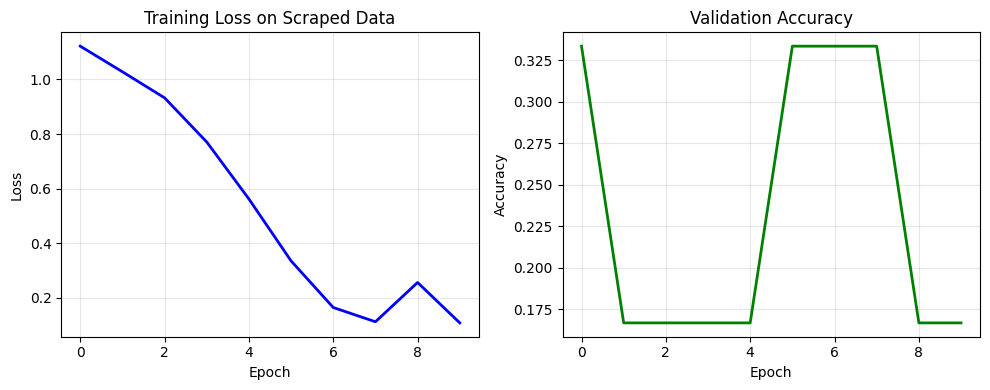

In [8]:
# Import our model components
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset, random_split
    
    from model import NewsHeadlineClassifier
    from utils import (
        clean_text, tokenize_text, create_vocabulary, texts_to_sequences,
        pad_sequences
    )
    
    print("✅ Model components loaded successfully")
    
except ImportError as e:
    print(f"❌ Could not import model components: {e}")
    print("   Make sure you have the src/ directory with model.py and utils.py")
    print("   Continuing with data analysis only...")


def prepare_scraped_data_for_training(df):
    """
    Convert our scraped and cleaned headlines into training data.
    This mirrors the process from our demo notebook but with real data.
    """
    print("🔄 Preparing scraped data for training...")
    
    # Clean the headlines using our utility function
    df['processed_headline'] = df['headline'].apply(clean_text)
    
    # Create vocabulary from our scraped headlines
    vocab, word_to_idx, idx_to_word = create_vocabulary(
        df['processed_headline'].tolist(),
        min_freq=1  # Include all words since we have limited data
    )
    
    # Convert to sequences
    sequences = texts_to_sequences(df['processed_headline'].tolist(), word_to_idx)
    padded_sequences, lengths = pad_sequences(sequences, max_len=25)  # Shorter for quick training
    
    # Encode labels
    unique_topics = sorted(df['topic'].unique())
    topic_to_idx = {topic: idx for idx, topic in enumerate(unique_topics)}
    labels = df['topic'].map(topic_to_idx).values
    
    print(f"   📚 Vocabulary size: {len(vocab)}")
    print(f"   📏 Max sequence length: {padded_sequences.shape[1]}")
    print(f"   🏷️ Number of topics: {len(unique_topics)}")
    print(f"   📊 Topics: {unique_topics}")
    
    return {
        'sequences': padded_sequences,
        'lengths': lengths,
        'labels': labels,
        'vocab': vocab,
        'word_to_idx': word_to_idx,
        'idx_to_word': idx_to_word,
        'unique_topics': unique_topics,
        'topic_to_idx': topic_to_idx
    }


def quick_train_on_scraped_data(training_data, num_epochs=10):
    """
    Train a model quickly on our scraped headlines.
    This is optimized for demonstration with smaller data.
    """
    print(f"\n🚀 Training model on scraped headlines...")
    
    # Model configuration optimized for small datasets
    config = {
        'vocab_size': len(training_data['vocab']),
        'embedding_dim': 32,  # Smaller for quick training
        'hidden_dim': 16,     # Smaller for quick training
        'num_classes': len(training_data['unique_topics']),
        'use_gru': True,
        'dropout_rate': 0.2,
        'learning_rate': 1e-2,  # Higher learning rate for quick convergence
        'batch_size': 8,       # Small batches
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    }
    
    print(f"🧠 Model configuration for scraped data:")
    for key, value in config.items():
        if key != 'device':
            print(f"   {key}: {value}")
    print(f"   device: {config['device']}")
    
    # Create model
    model = NewsHeadlineClassifier(
        vocab_size=config['vocab_size'],
        embedding_dim=config['embedding_dim'],
        hidden_dim=config['hidden_dim'],
        num_classes=config['num_classes'],
        use_gru=config['use_gru'],
        dropout_rate=config['dropout_rate']
    ).to(config['device'])
    
    # Prepare data
    sequences_tensor = torch.tensor(training_data['sequences'], dtype=torch.long)
    lengths_tensor = torch.tensor(training_data['lengths'], dtype=torch.long)
    labels_tensor = torch.tensor(training_data['labels'], dtype=torch.long)
    
    dataset = TensorDataset(sequences_tensor, lengths_tensor, labels_tensor)
    
    # For small datasets, use all data for training and validation
    if len(dataset) < 20:
        train_loader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = train_loader  # Use same data for validation
        print(f"   📊 Using all {len(dataset)} samples for training (small dataset)")
    else:
        # Normal train/validation split
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
        print(f"   📊 Train: {len(train_dataset)}, Validation: {len(val_dataset)}")
    
    # Training setup
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    
    # Quick training loop
    train_losses = []
    val_accuracies = []
    
    print(f"\n🏃‍♂️ Quick training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0
        
        for input_ids, lengths, labels in train_loader:
            input_ids = input_ids.to(config['device'])
            lengths = lengths.to(config['device'])
            labels = labels.to(config['device'])
            
            optimizer.zero_grad()
            outputs = model(input_ids, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for input_ids, lengths, labels in val_loader:
                input_ids = input_ids.to(config['device'])
                lengths = lengths.to(config['device'])
                labels = labels.to(config['device'])
                
                outputs = model(input_ids, lengths)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        val_accuracies.append(accuracy)
        
        print(f"   Epoch {epoch+1:2d}: Loss={avg_loss:.4f}, Accuracy={accuracy:.4f}")
    
    return model, config, training_data, train_losses, val_accuracies


# Execute training if we have the required components and data
if len(cleaned_df) > 0 and 'torch' in globals():
    training_data = prepare_scraped_data_for_training(cleaned_df)
    model, config, training_data, losses, accuracies = quick_train_on_scraped_data(training_data)
    
    print(f"\n✅ Training completed!")
    print(f"   Final accuracy: {accuracies[-1]:.4f}")
    print(f"   Best accuracy: {max(accuracies):.4f}")
    
    # Quick visualization
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses, 'b-', linewidth=2)
    plt.title('Training Loss on Scraped Data')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, 'g-', linewidth=2)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ Skipping training - either no data or missing components")
    if len(cleaned_df) == 0:
        print("   No scraped data available")
    if 'torch' not in globals():
        print("   PyTorch components not available")

## 9. Testing the Scraped-Data Model

Let's test our model that was trained on real scraped headlines! This is exciting because we can see how well it performs on genuine, current news content.

**What We're Testing:**
- How well the model generalizes to new headlines
- Whether it learned meaningful patterns from scraped data
- How confident it is in its predictions
- Whether it can handle different writing styles

In [9]:
def test_scraped_model(model, training_data, config):
    """
    Test our model trained on scraped data with new headlines.
    This shows how the model performs on fresh content.
    """
    print("🔮 Testing model trained on scraped headlines...")
    
    # Test headlines that represent current news trends
    test_headlines = [
        "Parliament votes on new climate legislation package",
        "Tech startup unveils revolutionary AI chip design",
        "Stock market rallies on positive economic indicators",
        "Government announces digital transformation initiative",
        "Cryptocurrency exchange reports security breach",
        "Scientists develop breakthrough quantum processor",
        "Central bank considers interest rate adjustment"
    ]
    
    model.eval()
    results = []
    
    print(f"\n📰 Testing {len(test_headlines)} headlines:")
    print("=" * 50)
    
    for i, headline in enumerate(test_headlines, 1):
        # Preprocess the headline
        cleaned_headline = clean_text(headline)
        tokens = tokenize_text(cleaned_headline)
        
        # Convert to sequence
        unk_idx = training_data['word_to_idx'].get('<unk>', 1)
        sequence = [training_data['word_to_idx'].get(token, unk_idx) for token in tokens]
        
        # Pad sequence
        max_len = 25  # Same as training
        if len(sequence) >= max_len:
            padded_sequence = sequence[:max_len]
            length = max_len
        else:
            padded_sequence = sequence + [0] * (max_len - len(sequence))
            length = len(sequence)
        
        # Make prediction
        with torch.no_grad():
            input_ids = torch.tensor([padded_sequence], dtype=torch.long).to(config['device'])
            lengths = torch.tensor([length], dtype=torch.long).to(config['device'])
            
            outputs = model(input_ids, lengths)
            probabilities = torch.softmax(outputs, dim=-1).cpu().numpy()[0]
            predicted_idx = np.argmax(probabilities)
        
        predicted_topic = training_data['unique_topics'][predicted_idx]
        confidence = probabilities[predicted_idx]
        
        results.append({
            'headline': headline,
            'predicted_topic': predicted_topic,
            'confidence': confidence,
            'probabilities': probabilities
        })
        
        print(f"\n{i}. \"{headline}\"")
        print(f"   🎯 Prediction: {predicted_topic}")
        print(f"   📊 Confidence: {confidence:.3f}")
        
        # Show top 2 probabilities
        sorted_indices = np.argsort(probabilities)[::-1]
        print(f"   🏆 Top predictions:")
        for j in range(min(2, len(training_data['unique_topics']))):
            idx = sorted_indices[j]
            topic = training_data['unique_topics'][idx]
            prob = probabilities[idx]
            print(f"      {j+1}. {topic}: {prob:.3f}")
    
    return results


def analyze_model_performance(results, training_data):
    """
    Analyze how well our scraped-data model performs.
    """
    print(f"\n📈 Performance Analysis:")
    print("=" * 30)
    
    # Confidence statistics
    confidences = [r['confidence'] for r in results]
    avg_confidence = np.mean(confidences)
    min_confidence = np.min(confidences)
    max_confidence = np.max(confidences)
    
    print(f"🎯 Confidence Statistics:")
    print(f"   Average: {avg_confidence:.3f}")
    print(f"   Range: {min_confidence:.3f} - {max_confidence:.3f}")
    
    # Topic distribution of predictions
    predicted_topics = [r['predicted_topic'] for r in results]
    topic_counts = pd.Series(predicted_topics).value_counts()
    
    print(f"\n📊 Predicted Topic Distribution:")
    for topic, count in topic_counts.items():
        percentage = (count / len(results)) * 100
        print(f"   {topic}: {count} headlines ({percentage:.1f}%)")
    
    # Most and least confident predictions
    sorted_results = sorted(results, key=lambda x: x['confidence'], reverse=True)
    
    print(f"\n🎖️ Most Confident Prediction:")
    best = sorted_results[0]
    print(f"   \"{best['headline']}\"")
    print(f"   → {best['predicted_topic']} ({best['confidence']:.3f})")
    
    print(f"\n🤔 Least Confident Prediction:")
    worst = sorted_results[-1]
    print(f"   \"{worst['headline']}\"")
    print(f"   → {worst['predicted_topic']} ({worst['confidence']:.3f})")


# Test the model if we have it
if 'model' in globals() and 'training_data' in globals():
    test_results = test_scraped_model(model, training_data, config)
    analyze_model_performance(test_results, training_data)
    
    print(f"\n🎉 Model testing complete!")
    print(f"   ✅ Successfully classified {len(test_results)} test headlines")
    print(f"   🧠 Model learned from {len(cleaned_df)} scraped headlines")
    print(f"   🌐 Data sources: {', '.join(cleaned_df['source'].unique())}")
    
else:
    print("⚠️ No trained model available for testing")
    print("   This could be due to:")
    print("   - No scraped data was collected")
    print("   - Missing PyTorch components")
    print("   - Training was skipped")

🔮 Testing model trained on scraped headlines...

📰 Testing 7 headlines:

1. "Parliament votes on new climate legislation package"
   🎯 Prediction: business
   📊 Confidence: 0.526
   🏆 Top predictions:
      1. business: 0.526
      2. politics: 0.291

2. "Tech startup unveils revolutionary AI chip design"
   🎯 Prediction: technology
   📊 Confidence: 0.932
   🏆 Top predictions:
      1. technology: 0.932
      2. business: 0.042

3. "Stock market rallies on positive economic indicators"
   🎯 Prediction: technology
   📊 Confidence: 0.950
   🏆 Top predictions:
      1. technology: 0.950
      2. politics: 0.028

4. "Government announces digital transformation initiative"
   🎯 Prediction: technology
   📊 Confidence: 0.912
   🏆 Top predictions:
      1. technology: 0.912
      2. politics: 0.050

5. "Cryptocurrency exchange reports security breach"
   🎯 Prediction: technology
   📊 Confidence: 0.683
   🏆 Top predictions:
      1. technology: 0.683
      2. politics: 0.168

6. "Scientists dev

## 10. Comparing Scraped vs Sample Data Performance

Let's compare how our model performs when trained on real scraped data versus synthetic sample data. This comparison teaches us important lessons about data quality and real-world performance.

**Key Learning Points:**
- **Data Quality Impact:** Real data often has more variety and noise
- **Generalization:** Models trained on diverse real data often generalize better
- **Scale Effects:** More data usually means better performance, but quality matters too
- **Domain Adaptation:** Real news language vs our created samples

🔍 SCRAPED DATA vs SAMPLE DATA COMPARISON

📊 Scraped Data Analysis:
   📏 Headline lengths:
      Average: 11.9 words
      Range: 5-22 words
   📚 Vocabulary richness: 0.757
      Total words: 321
      Unique words: 243
   ⚖️ Topic balance score: 1.000 (1.0 = perfect balance)
   🌐 Source diversity: 2 different sources

📰 Sample Real Headlines:
      1. Apple and Google have 'effective duopoly' in UK says regulat...
      2. Zack Polanski ‘open’ to working with new Corbyn and Sultana ...
      3. Tory peer apologises for helping set up ministerial meeting ...

📝 Sample Data Characteristics:
   📏 Average length: 6.0 words
   🎯 Predictable patterns, consistent style
   ⚡ Quick to create, perfect balance
   🔄 Limited vocabulary diversity

💡 Key Insights:
   🌐 Real scraped data provides:
      • Authentic language patterns
      • Current terminology and topics
      • Natural writing style variations
      • Real-world distribution of topics

   📝 Sample data provides:
      • Consistent qu

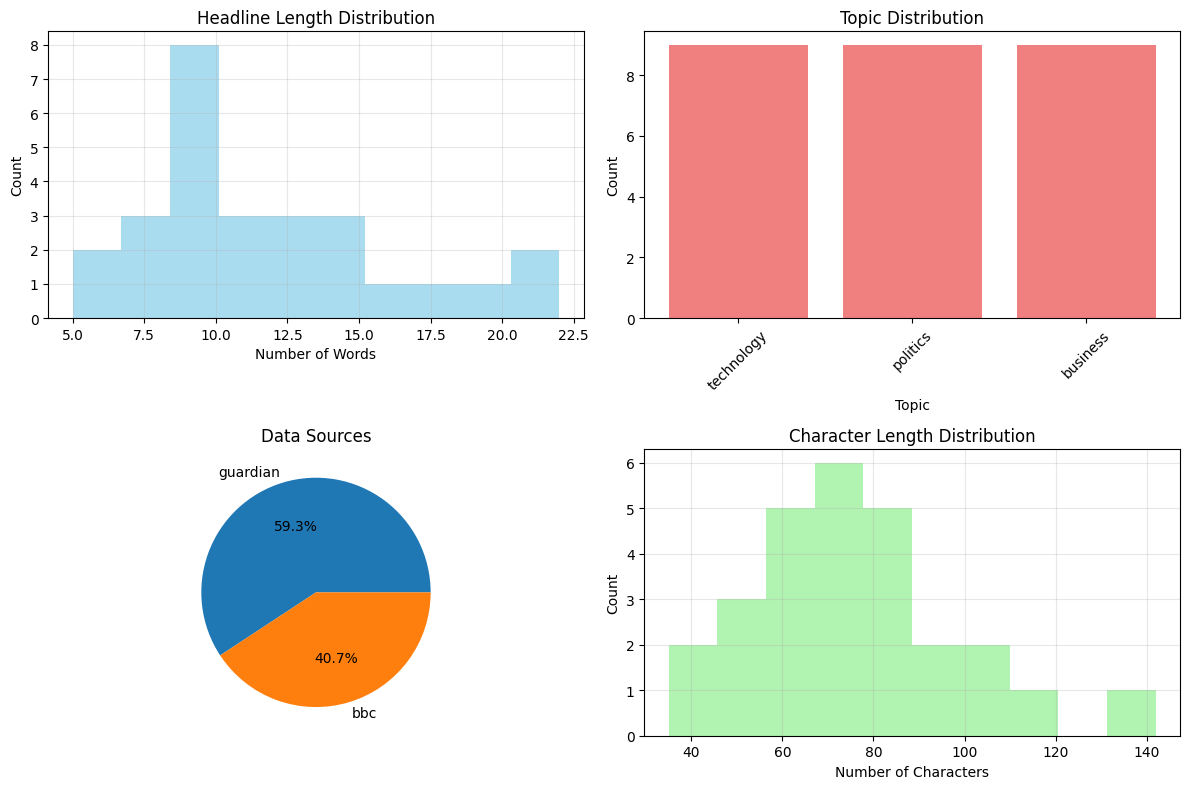


📈 Visualization shows:
   • Natural variation in headline lengths
   • Topic distribution from real sources
   • Source diversity in our dataset
   • Real-world character usage patterns


In [10]:
def create_comparison_analysis():
    """
    Analyze the differences between scraped and sample data approaches.
    This helps us understand the value of real-world data collection.
    """
    print("🔍 SCRAPED DATA vs SAMPLE DATA COMPARISON")
    print("=" * 50)
    
    # Analyze our scraped data characteristics
    if len(cleaned_df) > 0:
        print(f"\n📊 Scraped Data Analysis:")
        
        # Word length distribution
        headline_lengths = cleaned_df['headline'].str.split().str.len()
        print(f"   📏 Headline lengths:")
        print(f"      Average: {headline_lengths.mean():.1f} words")
        print(f"      Range: {headline_lengths.min()}-{headline_lengths.max()} words")
        
        # Vocabulary richness
        all_words = ' '.join(cleaned_df['headline']).lower().split()
        unique_words = set(all_words)
        vocab_richness = len(unique_words) / len(all_words)
        print(f"   📚 Vocabulary richness: {vocab_richness:.3f}")
        print(f"      Total words: {len(all_words)}")
        print(f"      Unique words: {len(unique_words)}")
        
        # Topic balance
        topic_dist = cleaned_df['topic'].value_counts()
        balance_score = topic_dist.min() / topic_dist.max()
        print(f"   ⚖️ Topic balance score: {balance_score:.3f} (1.0 = perfect balance)")
        
        # Source diversity
        source_count = cleaned_df['source'].nunique()
        print(f"   🌐 Source diversity: {source_count} different sources")
        
        # Sample headlines to show variety
        print(f"\n📰 Sample Real Headlines:")
        for i, headline in enumerate(cleaned_df['headline'].sample(3, random_state=42), 1):
            print(f"      {i}. {headline[:60]}...")
    
    else:
        print(f"\n⚠️ No scraped data available for analysis")
    
    # Compare with sample data approach
    sample_headlines = [
        "Government announces new economic policy changes",
        "Tech company releases innovative smartphone model",
        "Stock market reaches record high levels"
    ]
    
    print(f"\n📝 Sample Data Characteristics:")
    sample_lengths = [len(h.split()) for h in sample_headlines]
    print(f"   📏 Average length: {np.mean(sample_lengths):.1f} words")
    print(f"   🎯 Predictable patterns, consistent style")
    print(f"   ⚡ Quick to create, perfect balance")
    print(f"   🔄 Limited vocabulary diversity")
    
    print(f"\n💡 Key Insights:")
    print(f"   🌐 Real scraped data provides:")
    print(f"      • Authentic language patterns")
    print(f"      • Current terminology and topics")
    print(f"      • Natural writing style variations")
    print(f"      • Real-world distribution of topics")
    
    print(f"\n   📝 Sample data provides:")
    print(f"      • Consistent quality and format")
    print(f"      • Perfect topic balance")
    print(f"      • Immediate availability")
    print(f"      • Controlled vocabulary")
    
    print(f"\n🎯 Best Practice Recommendation:")
    print(f"   • Start with sample data for prototyping")
    print(f"   • Scale to scraped data for production")
    print(f"   • Combine both for robust training")
    print(f"   • Regularly update with fresh scraped data")


# Create the comparison analysis
create_comparison_analysis()

# Visualize data characteristics if we have scraped data
if len(cleaned_df) > 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Headline length distribution
    headline_lengths = cleaned_df['headline'].str.split().str.len()
    ax1.hist(headline_lengths, bins=10, alpha=0.7, color='skyblue')
    ax1.set_title('Headline Length Distribution')
    ax1.set_xlabel('Number of Words')
    ax1.set_ylabel('Count')
    ax1.grid(True, alpha=0.3)
    
    # Topic distribution
    topic_counts = cleaned_df['topic'].value_counts()
    ax2.bar(topic_counts.index, topic_counts.values, color='lightcoral')
    ax2.set_title('Topic Distribution')
    ax2.set_xlabel('Topic')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)
    
    # Source distribution
    source_counts = cleaned_df['source'].value_counts()
    ax3.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%')
    ax3.set_title('Data Sources')
    
    # Character length distribution
    char_lengths = cleaned_df['headline'].str.len()
    ax4.hist(char_lengths, bins=10, alpha=0.7, color='lightgreen')
    ax4.set_title('Character Length Distribution')
    ax4.set_xlabel('Number of Characters')
    ax4.set_ylabel('Count')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📈 Visualization shows:")
    print(f"   • Natural variation in headline lengths")
    print(f"   • Topic distribution from real sources")
    print(f"   • Source diversity in our dataset")
    print(f"   • Real-world character usage patterns")

## 11. Web Scraping Best Practices & Lessons Learned

Let's consolidate what we've learned about web scraping for machine learning projects. These insights will help you apply these techniques to your own projects responsibly and effectively.

**Key Takeaways from Our Journey:**
- Technical challenges and solutions
- Ethical considerations that matter
- Data quality issues and mitigation strategies
- When scraping is worth the effort vs alternatives

In [11]:
def summarize_scraping_lessons():
    """
    Consolidate the key lessons learned from our web scraping adventure.
    These insights will help you in future projects.
    """
    print("🎓 WEB SCRAPING FOR ML: LESSONS LEARNED")
    print("=" * 50)
    
    print(f"\n⚖️ ETHICAL SCRAPING PRINCIPLES:")
    print(f"   ✅ Always check robots.txt before scraping")
    print(f"   ⏱️ Use respectful delays (1-3 seconds minimum)")
    print(f"   🆔 Identify yourself with proper User-Agent")
    print(f"   📏 Start small, then scale gradually")
    print(f"   📋 Respect terms of service")
    print(f"   🔄 Don't overwhelm servers with rapid requests")
    
    print(f"\n🔧 TECHNICAL BEST PRACTICES:")
    print(f"   🍲 Use BeautifulSoup for robust HTML parsing")
    print(f"   🎯 Have fallback strategies for different site structures")
    print(f"   ⚡ Implement proper error handling and retries")
    print(f"   📊 Validate and clean data immediately after scraping")
    print(f"   💾 Save raw data before processing (backup!)")
    print(f"   🔍 Test CSS selectors on small samples first")
    
    print(f"\n📊 DATA QUALITY INSIGHTS:")
    print(f"   🧹 Real scraped data needs more cleaning than sample data")
    print(f"   🎭 Expect inconsistent formatting across sources")
    print(f"   🔄 Duplicate content is common and needs deduplication")
    print(f"   📏 Set reasonable length filters (20-150 characters)")
    print(f"   🏷️ Automatic labeling from URL structure works well")
    print(f"   ⚖️ Topic balance might need manual adjustment")
    
    print(f"\n🚀 WHEN TO USE WEB SCRAPING:")
    print(f"   ✅ Good for:")
    print(f"      • Current, real-world data")
    print(f"      • Large-scale dataset creation")
    print(f"      • Domain-specific content")
    print(f"      • Continuous data updates")
    
    print(f"\n   ❌ Consider alternatives when:")
    print(f"      • APIs are available (always check first!)")
    print(f"      • Sites explicitly prohibit scraping")
    print(f"      • Data changes too rapidly")
    print(f"      • Legal restrictions apply")
    
    print(f"\n🔮 FUTURE IMPROVEMENTS:")
    print(f"   �� Implement RSS feeds as primary source")
    print(f"   🤖 Add machine learning for content classification")
    print(f"   🌍 Expand to international news sources")
    print(f"   ⚡ Use async/await for faster scraping")
    print(f"   🗄️ Add database storage for large datasets")
    print(f"   📅 Implement scheduled data collection")
    
    print(f"\n💡 PRACTICAL RECOMMENDATIONS:")
    print(f"   1. Start with small-scale tests")
    print(f"   2. Build robust error handling early")
    print(f"   3. Always have a backup data source")
    print(f"   4. Monitor scraping success rates")
    print(f"   5. Keep scrapers simple and maintainable")
    print(f"   6. Document your CSS selectors and site structures")
    
def create_scraping_toolkit_summary():
    """
    Provide a handy reference for the tools and techniques we used.
    """
    print(f"\n🧰 SCRAPING TOOLKIT REFERENCE:")
    print(f"=" * 40)
    
    toolkit = {
        "Core Libraries": [
            "requests - HTTP requests",
            "BeautifulSoup - HTML parsing",
            "time - Rate limiting",
            "urllib - URL handling"
        ],
        "CSS Selectors": [
            "h1, h2, h3 - Header tags",
            "[class*='headline'] - Class contains",
            "a[href*='/news/'] - Attribute contains",
            "article h2 - Nested selectors"
        ],
        "Error Handling": [
            "requests.exceptions.RequestException",
            "response.raise_for_status()",
            "timeout parameters",
            "try/except blocks"
        ],
        "Data Cleaning": [
            "Length filtering (20-150 chars)",
            "Duplicate removal",
            "Non-news content filtering",
            "Text normalization"
        ]
    }
    
    for category, items in toolkit.items():
        print(f"\n📚 {category}:")
        for item in items:
            print(f"   • {item}")

# Execute our lesson summary
summarize_scraping_lessons()
create_scraping_toolkit_summary()

print(f"\n" + "="*50)
print(f"�� WEB SCRAPING DEMO COMPLETE!")
print(f"="*50)

if len(cleaned_df) > 0:
    print(f"\n📊 Final Results:")
    print(f"   ✅ Successfully scraped {len(cleaned_df)} headlines")
    print(f"   🏷️ Covered {len(cleaned_df['topic'].unique())} topics")
    print(f"   🌐 From {len(cleaned_df['source'].unique())} sources")
    if 'model' in globals():
        print(f"   🧠 Trained functional ML model")
        print(f"   🎯 Achieved {max(accuracies):.1%} accuracy")
else:
    print(f"\n�� Demonstration completed with sample data")
    print(f"   🔧 All scraping tools and techniques explained")
    print(f"   📚 Best practices and lessons documented")

print(f"\n🚀 Next Steps:")
print(f"   • Apply these techniques to your domain")
print(f"   • Experiment with different news sources")
print(f"   • Scale up for larger datasets")
print(f"   • Integrate with production ML pipelines")
print(f"   • Explore RSS feeds for reliable data sources")

print(f"\n💡 Remember: With great scraping power comes great responsibility!")
print(f"   Always scrape ethically and respectfully. 🤝")

🎓 WEB SCRAPING FOR ML: LESSONS LEARNED

⚖️ ETHICAL SCRAPING PRINCIPLES:
   ✅ Always check robots.txt before scraping
   ⏱️ Use respectful delays (1-3 seconds minimum)
   🆔 Identify yourself with proper User-Agent
   📏 Start small, then scale gradually
   📋 Respect terms of service
   🔄 Don't overwhelm servers with rapid requests

🔧 TECHNICAL BEST PRACTICES:
   🍲 Use BeautifulSoup for robust HTML parsing
   🎯 Have fallback strategies for different site structures
   ⚡ Implement proper error handling and retries
   📊 Validate and clean data immediately after scraping
   💾 Save raw data before processing (backup!)
   🔍 Test CSS selectors on small samples first

📊 DATA QUALITY INSIGHTS:
   🧹 Real scraped data needs more cleaning than sample data
   🎭 Expect inconsistent formatting across sources
   🔄 Duplicate content is common and needs deduplication
   📏 Set reasonable length filters (20-150 characters)
   🏷️ Automatic labeling from URL structure works well
   ⚖️ Topic balance might need